In [1]:
# imports 
import h5_utilities_module as h5u
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import eig
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from pathlib import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
from scipy.stats import zscore

In [2]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def calculate_trajectory_jerk(trajectory, time_window, dimensions=None):
    """Calculate trajectory jerkiness - higher values = less smooth"""
    if dimensions is None:
        # Use all dimensions
        path = trajectory[time_window[0]:time_window[1], :]
    else:
        path = trajectory[time_window[0]:time_window[1], dimensions]
   
    if len(path) < 3:  # Need at least 3 points for jerk calculation
        return np.nan
   
    # First derivative (velocity)
    velocity = np.diff(path, axis=0)
    # Second derivative (acceleration)
    acceleration = np.diff(velocity, axis=0)
   
    # Jerk magnitude at each timepoint
    jerk_magnitude = np.sqrt(np.sum(acceleration**2, axis=1))
   
    return np.mean(jerk_magnitude)  # Average jerkiness

def permutation_test_brain_area_difference(ofc_change, cdn_change, n_permutations=10000):
    """
    Test if CDN shows larger jerkiness increase than OFC using permutation test
    """
    # Observed difference between brain areas
    observed_diff = np.mean(cdn_change) - np.mean(ofc_change)
    
    # Combine all change scores
    all_changes = np.concatenate([ofc_change, cdn_change])
    n_ofc = len(ofc_change)
    n_cdn = len(cdn_change)
    
    # Permutation loop
    perm_diffs = []
    for i in range(n_permutations):
        # Randomly reassign brain area labels
        shuffled = np.random.permutation(all_changes)
        perm_ofc = shuffled[:n_ofc]
        perm_cdn = shuffled[n_ofc:n_ofc+n_cdn]
        
        # Calculate difference under permutation
        perm_diff = np.mean(perm_cdn) - np.mean(perm_ofc)
        perm_diffs.append(perm_diff)
    
    # Calculate p-value (two-tailed)
    perm_diffs = np.array(perm_diffs)
    p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_permutations
    
    return observed_diff, p_value, perm_diffs


def transmission_analysis(data_A, data_B, lags, time_step, win_size):
    """
    Perform sliding window transmission analysis between two neural time series.

    Tests directional predictive relationships by applying lagged regression analysis
    within sliding temporal windows. Based on the approach described in Crowe et al. 
    (2013) Nature Neuroscience for detecting information transmission between brain areas.

    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
        Neural data from brain area A (e.g., posterior probabilities from decoding).
        Should be preprocessed (e.g., ARIMA whitened) to remove autocorrelation.
    data_B : ndarray, shape (n_trials, n_times)  
        Neural data from brain area B, same format as data_A.
    lags : array_like
        Lag values to test (in time bins). Should start from 0.
        e.g., np.arange(0, 9) tests lags 0-8 bins.
    time_step : float
        Time duration of each bin in milliseconds (e.g., 25.0 for 25ms bins).
    win_size : float  
        Sliding window size in milliseconds (e.g., 500.0 for 500ms windows).
        
    Returns
    -------
    a2b_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area A predicts area B at each lag and time step.
        Higher values indicate stronger predictive relationships.
    b2a_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area B predicts area A at each lag and time step.
    bin_centers : ndarray, shape (n_time_steps,)
        Indices of original time bins corresponding to the center of each sliding window.
        Maps columns in a2b_f/b2a_f back to original data time points. 
    """

    n_samples = int(win_size / time_step)  # Convert to integer
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1  # Number of valid window positions
    
    # Initialize result arrays [n_lags x n_times]
    a2b_f = np.full((len(lags), n_time_steps), np.nan)
    b2a_f = np.full((len(lags), n_time_steps), np.nan)
    
    # Calculate bin centers for each window position
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over valid window positions
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
       
        # Extract windows from all trials
        a_window = data_A[:, window_start:window_end]  # [trials x window_bins]
        b_window = data_B[:, window_start:window_end]  # [trials x window_bins]
       
        for lag_ix, this_lag in enumerate(lags):
           
            # Test A -> B
            if this_lag > 0:
                a_pred = a_window[:, :-this_lag].flatten()  # Earlier A values
                b_targ = b_window[:, this_lag:].flatten()   # Later B values
            else:
                a_pred = a_window.flatten()
                b_targ = b_window.flatten()
               
            # Test B -> A 
            if this_lag > 0:
                b_pred = b_window[:, :-this_lag].flatten()  # Earlier B values
                a_targ = a_window[:, this_lag:].flatten()   # Later A values
            else:
                b_pred = b_window.flatten()
                a_targ = a_window.flatten()
           
            # Run regressions and compute F-statistics
            if len(a_pred) > 10:  # Minimum data check
                try:
                    X = sm.add_constant(a_pred)
                    model = sm.OLS(b_targ, X).fit()
                    a2b_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
                   
            if len(b_pred) > 10:
                try:
                    X = sm.add_constant(b_pred)  
                    model = sm.OLS(a_targ, X).fit()
                    b2a_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
               
    return a2b_f, b2a_f, bin_centers

def mahalanobis_from_manifold(lda_timecourse, value_centroids, lda_components=7):
    """
    Mahalanobis distance accounts for the shape/spread of the manifold.
    """
    from scipy.spatial.distance import mahalanobis
    
    n_trials, n_times, _ = lda_timecourse.shape
    lda_data = lda_timecourse[:, :, :lda_components]
    centroids = value_centroids[:, :lda_components]
    
    # Compute covariance of centroids
    cov = np.cov(centroids.T)
    cov_inv = np.linalg.pinv(cov)
    
    distances = np.zeros((n_trials, n_times))
    
    for t in range(n_times):
        for trial in range(n_trials):
            point = lda_data[trial, t, :]
            # Mahalanobis distance to nearest centroid
            dists = [mahalanobis(point, c, cov_inv) for c in centroids]
            distances[trial, t] = np.min(dists)
    
    return distances

def distance_from_manifold_vectorized(lda_timecourse, value_centroids, lda_components=7):
    """
    Euclidean distance to nearest centroid (vectorized for speed).
    """
    n_trials, n_times, _ = lda_timecourse.shape
    lda_data = lda_timecourse[:, :, :lda_components]  # (n_trials, n_times, n_comp)
    centroids = value_centroids[:, :lda_components]    # (n_centroids, n_comp)
    
    distances = np.zeros((n_trials, n_times))
    
    # Vectorize over time and centroids
    for t in range(n_times):
        points = lda_data[:, t, :]  # (n_trials, n_comp)
        
        # Compute distances from all points to all centroids at once
        # Broadcasting: (n_trials, 1, n_comp) - (1, n_centroids, n_comp)
        diffs = points[:, np.newaxis, :] - centroids[np.newaxis, :, :]  # (n_trials, n_centroids, n_comp)
        dists = np.linalg.norm(diffs, axis=2)  # (n_trials, n_centroids)
        
        # Take minimum distance for each trial
        distances[:, t] = np.min(dists, axis=1)  # (n_trials,)
    
    return distances

def compute_trajectory_metrics(lda_timecourse, lda_components=None, step_size=1):
    n_trials, n_times, n_components = lda_timecourse.shape
    
    # Select which LDA components to use
    if lda_components is None:
        lda_data = lda_timecourse
    elif isinstance(lda_components, int):
        lda_data = lda_timecourse[:, :, :lda_components]
    else:
        lda_data = lda_timecourse[:, :, lda_components]
    
    # Compute velocity using central differences with step_size
    # velocity[t] = (position[t+step] - position[t-step]) / (2*step)
    velocity_vectors = np.zeros_like(lda_data)
    velocity_vectors[:, step_size:-step_size, :] = (
        lda_data[:, 2*step_size:, :] - lda_data[:, :-2*step_size, :]
    ) / (2 * step_size)
    
    # For acceleration
    acc_vectors = np.zeros_like(velocity_vectors)
    acc_vectors[:, step_size:-step_size, :] = (
        velocity_vectors[:, 2*step_size:, :] - velocity_vectors[:, :-2*step_size, :]
    ) / (2 * step_size)
    
    # For jerk
    jerk_vectors = np.zeros_like(acc_vectors)
    jerk_vectors[:, step_size:-step_size, :] = (
        acc_vectors[:, 2*step_size:, :] - acc_vectors[:, :-2*step_size, :]
    ) / (2 * step_size)
    
    # Compute Euclidean norms
    lda_velocity = np.linalg.norm(velocity_vectors, axis=2)
    lda_acc = np.linalg.norm(acc_vectors, axis=2)
    lda_jerk = np.linalg.norm(jerk_vectors, axis=2)
    
    return lda_velocity, lda_acc, lda_jerk


from scipy.ndimage import gaussian_filter1d

def compute_trajectory_metrics_gaussian(lda_timecourse, lda_components=None, sigma=2):
    """
    Compute velocity with Gaussian smoothing.
    
    Parameters
    ----------
    sigma : float
        Standard deviation for Gaussian kernel. 
        Larger = more smoothing.
    """
    n_trials, n_times, n_components = lda_timecourse.shape
    
    # Select LDA components
    if lda_components is None:
        lda_data = lda_timecourse
    elif isinstance(lda_components, int):
        lda_data = lda_timecourse[:, :, :lda_components]
    else:
        lda_data = lda_timecourse[:, :, lda_components]
    
    # Smooth each LDA component for each trial
    lda_data_smooth = np.zeros_like(lda_data)
    for trial in range(n_trials):
        for comp in range(lda_data.shape[2]):
            lda_data_smooth[trial, :, comp] = gaussian_filter1d(
                lda_data[trial, :, comp], 
                sigma=sigma
            )
    
    # Compute derivatives on smoothed data
    velocity_vectors = np.gradient(lda_data_smooth, axis=1)
    acc_vectors = np.gradient(velocity_vectors, axis=1)
    jerk_vectors = np.gradient(acc_vectors, axis=1)
    
    lda_velocity = np.linalg.norm(velocity_vectors, axis=2)
    lda_acc = np.linalg.norm(acc_vectors, axis=2)
    lda_jerk = np.linalg.norm(jerk_vectors, axis=2)
    
    return lda_velocity, lda_acc, lda_jerk

In [3]:
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder\D20231219_Rec05.h5':
CdN_FR
CdN_channels
CdN_lfp
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_lfp
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
chan_map
lfp_ts
ts


In [4]:
this_file = data_files[4]

In [5]:

f_name = Path(this_file).stem
print(f_name)

if 'D' in f_name:
    s = 0
else:
    s = 1


# pull the data for this file
# access the data for this session
ofc_firing_rates = h5u.pull_from_h5(this_file, 'OFC_zFR')
cdn_firing_rates = h5u.pull_from_h5(this_file, 'CdN_zFR')
                        
# figure out how many neurons we have
n_OFC = h5u.pull_from_h5(this_file, 'OFC_zFR').shape[2]
n_CdN = h5u.pull_from_h5(this_file, 'CdN_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

# pull out the time step index and the behavior
ts = h5u.pull_from_h5(this_file, 'ts')
bhv = pd.read_hdf(this_file, key='bhv')

# make sure the behavioral data has the same number of trials as the firing rates
if len(bhv) > len(ofc_firing_rates):
    bhv = bhv.loc[0 :len(ofc_firing_rates)-1]

# set any nan values to zero (necessary for the decoder)
ofc_firing_rates = np.nan_to_num(ofc_firing_rates, nan=0)
cdn_firing_rates = np.nan_to_num(cdn_firing_rates, nan=0)

# get indices of the choice period
pics_on = np.argwhere(ts == 25)[0][0]
pics_end = np.argwhere(ts == 400)[0][0]

# get the mean firing rate for the choice period for both brain areas
ofc_choice_frs = np.mean(ofc_firing_rates[:,pics_on:pics_end,:], axis=1)
cdn_choice_frs = np.mean(cdn_firing_rates[:,pics_on:pics_end,:], axis=1)

# get the labels associated with each unique state-value pair
ch_val, unch_val = get_ch_and_unch_vals(bhv)
s_ch_val = ch_val.copy()
s_unch_val = unch_val.copy()

s_ch_val[bhv['state'] == 2] = s_ch_val[bhv['state'] == 2] + 4
s_ch_val[bhv['state'] == 3] = s_ch_val[bhv['state'] == 3] + 8
s_unch_val[bhv['state'] == 2] = s_unch_val[bhv['state'] == 2] + 4
s_unch_val[bhv['state'] == 3] = s_unch_val[bhv['state'] == 3] + 8

n_trials, n_times, n_ofc = np.shape(ofc_firing_rates)

valid_trials = ((bhv['forced'] == 1) | (bhv['n_sacc'] == 1)) & (bhv['state'] < 3)

# First, do the PCA
n_ofc_trials, n_ofc_time, n_ofc_neurons = ofc_firing_rates.shape
n_cdn_trials, n_cdn_time, n_cdn_neurons = cdn_firing_rates.shape

valid_ofc_reshaped = ofc_firing_rates[valid_trials,:,:].reshape(-1, n_ofc_neurons)
valid_cdn_reshaped = cdn_firing_rates[valid_trials,:,:].reshape(-1, n_cdn_neurons)

all_ofc_reshaped = ofc_firing_rates.reshape(-1, n_ofc_neurons)
all_cdn_reshaped = cdn_firing_rates.reshape(-1, n_cdn_neurons)

# Fit PCA
ofc_pca = PCA(n_components=100)
cdn_pca = PCA(n_components=100)

ofc_pca.fit(valid_ofc_reshaped)
cdn_pca.fit(valid_cdn_reshaped)

ofc_pc_scores = ofc_pca.transform(all_ofc_reshaped)
cdn_pc_scores = cdn_pca.transform(all_cdn_reshaped)

# Reshape back to [trials, time, n_components]
ofc_pc_timecourse = ofc_pc_scores.reshape(n_ofc_trials, n_ofc_time, -1)
cdn_pc_timecourse = cdn_pc_scores.reshape(n_cdn_trials, n_cdn_time, -1)

K20240707_Rec06


In [6]:
# now let's get the mean saccade-aligned PCs and we'll use that to define the optimal axes to project the timecourse pcs onto
n_pcs = ofc_pc_timecourse.shape[2]

ts_offset = [3, 11] # use first 225 ms from sacc 1

# initialize arrays to accumulate data into
ofc_mean_sacc1_pps = np.full((n_trials, n_pcs), np.nan)
cdn_mean_sacc1_pps = np.full((n_trials, n_pcs), np.nan)

ofc_mean_sacc1_fr = np.full((n_trials, n_OFC), np.nan)
cdn_mean_sacc1_fr = np.full((n_trials, n_CdN), np.nan)

# loop over individual trials
for t in tqdm(range(n_trials)):

    # only analyze single-saccade trials
    if bhv['n_sacc'].iloc[t] == 1:

        # get index of the first saccade on this trial
        t_sacc1_time_ix = np.argmin(np.abs(bhv['sacc1_t'].iloc[t] - ts))
        # t_sacc1_time_ix = np.argmin(np.abs(0 - ts))
        # ts_offset = [0, 15] # use first 225 ms from sacc 1

        t_sacc1_start =  t_sacc1_time_ix + ts_offset[0]
        ts_sacc1_end = t_sacc1_time_ix + ts_offset[1]

        # get the pcs right after the saccade for this trial
        t_ofc_pcs = ofc_pc_timecourse[t, t_sacc1_start:ts_sacc1_end, :]
        t_cdn_pcs = cdn_pc_timecourse[t, t_sacc1_start:ts_sacc1_end, :]

        # get their mean value
        ofc_mean_sacc1_pps[t,:] = np.nanmean(t_ofc_pcs, axis=0)
        cdn_mean_sacc1_pps[t,:] = np.nanmean(t_cdn_pcs, axis=0)

        # get the firing rates right after the saccade
        t_ofc_fr = ofc_firing_rates[t, t_sacc1_start:ts_sacc1_end, :]
        t_cdn_fr = cdn_firing_rates[t, t_sacc1_start:ts_sacc1_end, :]

        # get their mean value
        ofc_mean_sacc1_fr[t,:] = np.nanmean(t_ofc_fr, axis=0)
        cdn_mean_sacc1_fr[t,:] = np.nanmean(t_cdn_fr, axis=0)

100%|██████████| 1212/1212 [00:00<00:00, 21262.12it/s]


In [7]:
# DO LDA TRANSFORMATION ON FIRING RATES

# Prepare the data and labels for LDA
# Create state-value labels
state_val_labels = bhv['state'].values * 10 + bhv['ch_val'].values  # e.g., 11, 12, 13, 14, 21, 22, 23, 24

# Select valid trials (single saccade, states 1 and 2)
valid_for_lda = (bhv['n_sacc'] == 1) & (bhv['state'] < 3)

# Get the valid data and labels
ofc_lda_input = ofc_mean_sacc1_fr[valid_for_lda, :]
cdn_lda_input = cdn_mean_sacc1_fr[valid_for_lda, :]
labels = state_val_labels[valid_for_lda]

# Remove any remaining NaN rows
ofc_valid_mask = ~np.isnan(ofc_lda_input).any(axis=1)
cdn_valid_mask = ~np.isnan(cdn_lda_input).any(axis=1)

ofc_lda_input_clean = ofc_lda_input[ofc_valid_mask, :]
cdn_lda_input_clean = cdn_lda_input[cdn_valid_mask, :]
ofc_labels_clean = labels[ofc_valid_mask]
cdn_labels_clean = labels[cdn_valid_mask]

# Fit LDA on the post-saccade PC data
ofc_lda = LinearDiscriminantAnalysis()
cdn_lda = LinearDiscriminantAnalysis()

ofc_lda.fit(ofc_lda_input_clean, ofc_labels_clean)
cdn_lda.fit(cdn_lda_input_clean, cdn_labels_clean)

# Get number of LDA components
ofc_n_components = ofc_lda.transform(ofc_lda_input_clean).shape[1]
cdn_n_components = cdn_lda.transform(cdn_lda_input_clean).shape[1]


# Calculate mean locations in LDA space for each state-value combination
state_val_combinations = np.array([[1, 1],
                                    [1, 2],
                                    [1, 3],
                                    [1, 4],
                                    [2, 1],
                                    [2, 2],
                                    [2, 3],
                                    [2, 4]])

# Transform the valid data to get means
ofc_lda_transformed_valid = ofc_lda.transform(ofc_lda_input_clean)
cdn_lda_transformed_valid = cdn_lda.transform(cdn_lda_input_clean)

ofc_lda_means = np.zeros((len(state_val_combinations), ofc_n_components))
cdn_lda_means = np.zeros((len(state_val_combinations), cdn_n_components))

# Get the original trial indices back
ofc_valid_trials = np.where(valid_for_lda)[0][ofc_valid_mask]
cdn_valid_trials = np.where(valid_for_lda)[0][cdn_valid_mask]

for i, (state, value) in enumerate(state_val_combinations):
    # For OFC
    ofc_mask = (bhv.iloc[ofc_valid_trials]['state'] == state) & (bhv.iloc[ofc_valid_trials]['ch_val'] == value)
    if np.sum(ofc_mask) > 0:
        ofc_lda_means[i, :] = np.mean(ofc_lda_transformed_valid[ofc_mask, :], axis=0)
    
    # For CDN
    cdn_mask = (bhv.iloc[cdn_valid_trials]['state'] == state) & (bhv.iloc[cdn_valid_trials]['ch_val'] == value)
    if np.sum(cdn_mask) > 0:
        cdn_lda_means[i, :] = np.mean(cdn_lda_transformed_valid[cdn_mask, :], axis=0)


# project all timecourse data into this LDA space

# Get dimensions

# Reshape to 2D: (trials * times) × n_units
ofc_fr_reshaped = ofc_firing_rates.reshape(-1, n_OFC)
cdn_fr_reshaped = cdn_firing_rates.reshape(-1, n_CdN)

# Transform into LDA space
ofc_ld_transformed = ofc_lda.transform(ofc_fr_reshaped)
cdn_ld_transformed = cdn_lda.transform(cdn_fr_reshaped)

# Reshape back to 3D: trials × times × LD_components
ofc_lda_timecourse = ofc_ld_transformed.reshape(n_trials, n_times, -1)
cdn_lda_timecourse = cdn_ld_transformed.reshape(n_trials, n_times, -1)

In [8]:
# # DO LDA TRANSFORMATION ON PCS

# # Prepare the data and labels for LDA
# # Create state-value labels
# state_val_labels = bhv['state'].values * 10 + bhv['ch_val'].values  # e.g., 11, 12, 13, 14, 21, 22, 23, 24

# valid_for_lda = (bhv['n_sacc'] == 1) & (bhv['state'] < 3)

# # Get the valid data and labels
# ofc_lda_input = ofc_mean_sacc1_pps[valid_for_lda, :]
# cdn_lda_input = cdn_mean_sacc1_pps[valid_for_lda, :]
# labels = state_val_labels[valid_for_lda]

# # Remove any remaining NaN rows
# ofc_valid_mask = ~np.isnan(ofc_lda_input).any(axis=1)
# cdn_valid_mask = ~np.isnan(cdn_lda_input).any(axis=1)

# ofc_lda_input_clean = ofc_lda_input[ofc_valid_mask, :]
# cdn_lda_input_clean = cdn_lda_input[cdn_valid_mask, :]
# ofc_labels_clean = labels[ofc_valid_mask]
# cdn_labels_clean = labels[cdn_valid_mask]

# print(f"OFC: Using {len(ofc_labels_clean)} trials for LDA")
# print(f"CDN: Using {len(cdn_labels_clean)} trials for LDA")

# # Fit LDA on the post-saccade PC data
# ofc_lda = LinearDiscriminantAnalysis()
# cdn_lda = LinearDiscriminantAnalysis()

# ofc_lda.fit(ofc_lda_input_clean, ofc_labels_clean)
# cdn_lda.fit(cdn_lda_input_clean, cdn_labels_clean)

# # Get number of LDA components
# ofc_n_components = ofc_lda.transform(ofc_lda_input_clean).shape[1]
# cdn_n_components = cdn_lda.transform(cdn_lda_input_clean).shape[1]


# # Calculate mean locations in LDA space for each state-value combination
# state_val_combinations = np.array([[1, 1],
#                                     [1, 2],
#                                     [1, 3],
#                                     [1, 4],
#                                     [2, 1],
#                                     [2, 2],
#                                     [2, 3],
#                                     [2, 4], 
#                                     ])

# # Transform the valid data to get means
# ofc_lda_transformed_valid = ofc_lda.transform(ofc_lda_input_clean)
# cdn_lda_transformed_valid = cdn_lda.transform(cdn_lda_input_clean)

# ofc_lda_means = np.zeros((len(state_val_combinations), ofc_n_components))
# cdn_lda_means = np.zeros((len(state_val_combinations), cdn_n_components))

# # Get the original trial indices back
# ofc_valid_trials = np.where(valid_for_lda)[0][ofc_valid_mask]
# cdn_valid_trials = np.where(valid_for_lda)[0][cdn_valid_mask]

# for i, (state, value) in enumerate(state_val_combinations):
#     # For OFC
#     ofc_mask = (bhv.iloc[ofc_valid_trials]['state'] == state) & (bhv.iloc[ofc_valid_trials]['ch_val'] == value)
#     if np.sum(ofc_mask) > 0:
#         ofc_lda_means[i, :] = np.mean(ofc_lda_transformed_valid[ofc_mask, :], axis=0)
    
#     # For CDN
#     cdn_mask = (bhv.iloc[cdn_valid_trials]['state'] == state) & (bhv.iloc[cdn_valid_trials]['ch_val'] == value)
#     if np.sum(cdn_mask) > 0:
#         cdn_lda_means[i, :] = np.mean(cdn_lda_transformed_valid[cdn_mask, :], axis=0)

# # project all timecourse data into this LDA space

# # Get dimensions
# n_trials, n_times, n_pcs = ofc_pc_timecourse.shape

# # Reshape to 2D: (trials * times) × PCs
# ofc_pc_reshaped = ofc_pc_timecourse.reshape(-1, n_pcs)
# cdn_pc_reshaped = cdn_pc_timecourse.reshape(-1, n_pcs)

# # Transform into LDA space
# ofc_ld_transformed = ofc_lda.transform(ofc_pc_reshaped)
# cdn_ld_transformed = cdn_lda.transform(cdn_pc_reshaped)

# # Reshape back to 3D: trials × times × LD_components
# ofc_lda_timecourse = ofc_ld_transformed.reshape(n_trials, n_times, -1)
# cdn_lda_timecourse = cdn_ld_transformed.reshape(n_trials, n_times, -1)

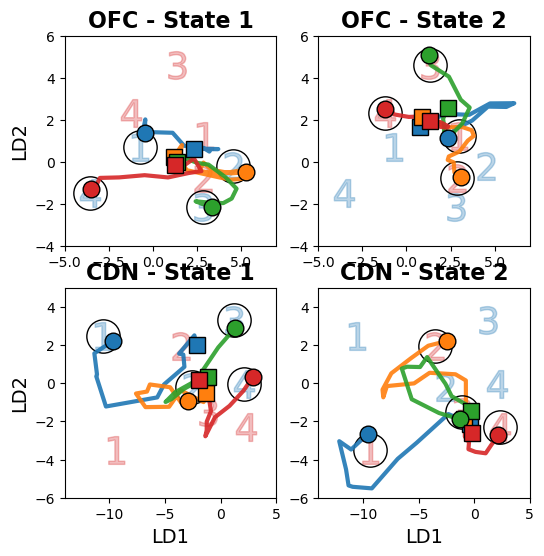

In [9]:
# Define time window for visualization
pics_on_ix = np.argmin(np.abs(ts - 0))  

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# Define which LD axes to plot
ld_x_ax, ld_y_ax = 0, 1  # LD1 vs LD2

# Define colors for the 4 values
value_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, orange, green, red

# Define axis limits for each brain area
ofc_xlim = [-5, 7]  
ofc_ylim = [-4, 6]  
cdn_xlim = [-14, 5]    
cdn_ylim = [-6, 5]   

# Loop through each brain area (OFC = row 0, CDN = row 1)
for area_idx, (area_name, lda_means, lda_timecourse, xlim, ylim) in enumerate([
    ('OFC', ofc_lda_means, ofc_lda_timecourse, ofc_xlim, ofc_ylim),
    ('CDN', cdn_lda_means, cdn_lda_timecourse, cdn_xlim, cdn_ylim)
]):
    
    # Loop through each state (State 1 = col 0, State 2 = col 1)
    for state_idx, state in enumerate([1, 2]):
        
        ax = axes[area_idx, state_idx]
        
        # Plot all state-value targets (faded) for reference
        markers = ['$1$', '$2$', '$3$', '$4$']
        colors_state = ['tab:blue', 'tab:red']
        
        for i in range(len(state_val_combinations)):
            s_idx = state_val_combinations[i, 0] - 1
            v_idx = state_val_combinations[i, 1] - 1
            
            ax.plot(lda_means[i, ld_x_ax], lda_means[i, ld_y_ax],
                   marker=markers[v_idx], color=colors_state[s_idx], 
                   markersize=20, alpha=0.3)
        
        # Loop through each value in this state
        for value in [1, 2, 3, 4]:
            
            # Find single saccade trials for this state-value combination
            trials2use = (bhv['state'] == state) & (bhv['ch_val'] == value) & (bhv['n_sacc'] == 1)
            
            if np.sum(trials2use) == 0:
                print(f"Warning: No trials for {area_name} State {state}, Value {value}")
                continue
            
            # Get combo index for target location
            combo_idx = (state - 1) * 4 + (value - 1)
            
            # Highlight this state-value target with a circle
            ax.plot(lda_means[combo_idx, ld_x_ax], lda_means[combo_idx, ld_y_ax],
                   'o', markersize=24, fillstyle='none', color='black', linewidth=4)
            
            # Get the choice end time (matching your working code: sacc + 200ms)
            sacc_time = np.nanmean(bhv['sacc1_t'].loc[trials2use]-1)
            choice_end_ix = np.argmin(np.abs(ts - (sacc_time + 150)))
            
            # Get mean trajectory
            mean_traj = np.nanmean(lda_timecourse[trials2use, :, :], axis=0)
            
            # Plot trajectory
            traj_x = mean_traj[pics_on_ix:choice_end_ix, ld_x_ax]
            traj_y = mean_traj[pics_on_ix:choice_end_ix, ld_y_ax]
            
            trajectory_color = value_colors[value - 1]
            
            ax.plot(traj_x, traj_y, color=trajectory_color, linewidth=3, alpha=0.9, 
                   label=f'Value {value} ({int(np.sum(trials2use))} trials)')
            
            # Mark the start point
            ax.plot(traj_x[0], traj_y[0], marker='s', color=trajectory_color, 
                   markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
            
            # Mark the end point
            ax.plot(traj_x[-1], traj_y[-1], marker='o', color=trajectory_color, 
                   markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
        
        # Formatting
        ax.set_title(f'{area_name} - State {state}', fontsize=16, fontweight='bold')
        
        # Set axis limits
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # Only add x-label on bottom row
        if area_idx == 1:
            ax.set_xlabel(f'LD{ld_x_ax+1}', fontsize=14)
        
        # Only add y-label on left column
        if state_idx == 0:
            ax.set_ylabel(f'LD{ld_y_ax+1}', fontsize=14)
        
        #ax.legend(loc='best', fontsize=10, framealpha=0.9)

# save the figure
#plt.savefig('all_mean_trajectories.svg')

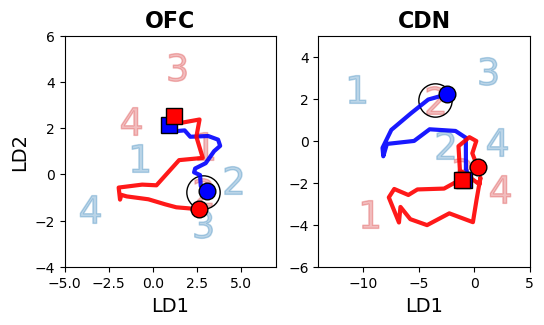

In [10]:
# Define state-value combinations
state_val_combinations = np.array([[1, 1],
                                    [1, 2],
                                    [1, 3],
                                    [1, 4],
                                    [2, 1],
                                    [2, 2],
                                    [2, 3],
                                    [2, 4]])

# Define time window for visualization
pics_on_ix = np.argmin(np.abs(ts - 0))  

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Define which LD axes to plot
ld_x_ax, ld_y_ax = 0, 1  # LD1 vs LD2

# Define axis limits for each brain area
ofc_xlim = [-5, 7]  
ofc_ylim = [-4, 6]  
cdn_xlim = [-14, 5]    
cdn_ylim = [-6, 5]    

# Define the specific condition
state_to_plot = 2
chosen_val = 2
unchosen_val = 1

# Loop through each brain area (OFC = 0, CDN = 1)
for area_idx, (area_name, lda_means, lda_timecourse, xlim, ylim) in enumerate([
    ('OFC', ofc_lda_means, ofc_lda_timecourse, ofc_xlim, ofc_ylim),
    ('CDN', cdn_lda_means, cdn_lda_timecourse, cdn_xlim, cdn_ylim)
]):
    
    ax = axes[area_idx]
    
    # Plot all state-value targets (faded) for reference
    markers = ['$1$', '$2$', '$3$', '$4$']
    colors_state = ['tab:blue', 'tab:red']
    
    for i in range(len(state_val_combinations)):
        s_idx = state_val_combinations[i, 0] - 1
        v_idx = state_val_combinations[i, 1] - 1
        
        ax.plot(lda_means[i, ld_x_ax], lda_means[i, ld_y_ax],
               marker=markers[v_idx], color=colors_state[s_idx], 
               markersize=20, alpha=0.3)
    
    # Highlight the target (State 1, Value 2)
    target_idx = (state_to_plot - 1) * 4 + (chosen_val - 1)
    ax.plot(lda_means[target_idx, ld_x_ax], lda_means[target_idx, ld_y_ax],
           'o', markersize=24, fillstyle='none', color='black', linewidth=4)
    
    # Get single saccade trials
    single_trials = (bhv['state'] == state_to_plot) & \
                   (bhv['ch_val'] == chosen_val) & \
                   (bhv['n_sacc'] == 1)
    
    # Get double saccade trials
    double_trials = (bhv['state'] == state_to_plot) & \
                   (bhv['ch_val'] == chosen_val) & \
                   (unch_val == unchosen_val) & \
                   (bhv['n_sacc'] == 2)
        
    # Plot single saccade trajectory
    if np.sum(single_trials) > 0:
        sacc_time_single = np.nanmean(bhv['sacc1_t'].loc[single_trials] - 1)
        choice_end_ix_single = np.argmin(np.abs(ts - (sacc_time_single + 150)))
        
        mean_traj_single = np.nanmean(lda_timecourse[single_trials, :, :], axis=0)
        
        traj_x_single = mean_traj_single[pics_on_ix:choice_end_ix_single, ld_x_ax]
        traj_y_single = mean_traj_single[pics_on_ix:choice_end_ix_single, ld_y_ax]
        
        ax.plot(traj_x_single, traj_y_single, color='blue', linewidth=3, alpha=0.9, 
               label=f'Single saccade (n={int(np.sum(single_trials))})')
        
        # Mark start and end
        ax.plot(traj_x_single[0], traj_y_single[0], marker='s', color='blue', 
               markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
        ax.plot(traj_x_single[-1], traj_y_single[-1], marker='o', color='blue', 
               markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
    
    # Plot double saccade trajectory
    if np.sum(double_trials) > 0:
        sacc_time_double = np.nanmean(bhv['sacc2_t'].loc[double_trials] - 1)
        choice_end_ix_double = np.argmin(np.abs(ts - (sacc_time_double + 250)))
        
        mean_traj_double = np.nanmean(lda_timecourse[double_trials, :, :], axis=0)
        
        traj_x_double = mean_traj_double[pics_on_ix:choice_end_ix_double, ld_x_ax]
        traj_y_double = mean_traj_double[pics_on_ix:choice_end_ix_double, ld_y_ax]
        
        ax.plot(traj_x_double, traj_y_double, color='red', linewidth=3, alpha=0.9, 
               label=f'Double saccade (n={int(np.sum(double_trials))})')
        
        # Mark start and end
        ax.plot(traj_x_double[0], traj_y_double[0], marker='s', color='red', 
               markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
        ax.plot(traj_x_double[-1], traj_y_double[-1], marker='o', color='red', 
               markersize=12, zorder=10, markeredgecolor='black', markeredgewidth=1)
    
    # Formatting
    ax.set_title(f'{area_name}', fontsize=16, fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(f'LD{ld_x_ax+1}', fontsize=14)
    
    if area_idx == 0:
        ax.set_ylabel(f'LD{ld_y_ax+1}', fontsize=14)
    
# save the figure
#fig.savefig('matched_trajectories.svg')